# ResNet model on Fashion-Minst data set


importing most libraries


In [13]:

# Importing required libraries
from torchvision import datasets, transforms
# PyTorch can extract datasets from GitHub
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython import get_ipython
from IPython.display import display


**Data preperation**

dowanloading the data from github to the colab notebook.
preforming data agumentation.

 adding channels so it would preform like rgb and work withe resnet.

split the data to validation test and train.

In [14]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# Loading the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Splitting into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Printing dataset sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 196kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.68MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.31MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Number of training samples: 48000
Number of validation samples: 12000
Number of test samples: 10000


# early stop
creating a logic in case an early stop is nedded.

In [15]:
class EarlyStopping:
    def __init__(self, patience, verbose):
        self.patience = patience
        #using verbose to alert in a case of early stopping
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = None

    def __call__(self, val_loss,model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                self.early_stop = True


# creating the model



*  using a pretrained resnrt 18 model.

*   changing the output to match the dataset (10).


*   freezing the conv layers
*   traning only the fully connected layers becuse thats where they differ.

finaly chossing **cross entropy** loss function and dg **adam**
optomizer





In [16]:
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = resnet18(pretrained=True)
#changeing the number of outpust in the fc layer
num_output = 10
model.fc = nn.Linear(model.fc.in_features, num_output)
#Freeze Convolutional Layers (allready trained layers)
for param in model.parameters():
    param.requires_grad = False
#Unfreeze Fully Connected Layers
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # The loss function used
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=False)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.6MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

# Traning and validation.
traning only the last layers and using validation to get better results.

**fine tuning:**

after the first few attemtets the model reached accuracy of around 87%.

to get better results i added a loop to unfreeze the layers after 5 epoches.

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

epochs = 10
early_stopping = EarlyStopping(patience=5, verbose=False)

# Metrics storage
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Optimizer and scheduler initialization
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=False)

for epoch in range(epochs):
    # Unfreeze layers after epoch 5
    if epoch == 5:
        for param in model.parameters():
            param.requires_grad = True
        print("Unfreezing all layers!")

    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss.append(avg_train_loss)
    train_acc.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_running_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss.append(avg_val_loss)
    val_acc.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Load the best model state
model.load_state_dict(early_stopping.best_model)
torch.save(early_stopping.best_model, 'best_model.pth')



Epoch [1/10], Training Loss: 0.6519, Training Accuracy: 0.7921
Epoch [1/10], Validation Loss: 0.4813, Validation Accuracy: 0.8327
Epoch [2/10], Training Loss: 0.4554, Training Accuracy: 0.8405
Epoch [2/10], Validation Loss: 0.4153, Validation Accuracy: 0.8539
Epoch [3/10], Training Loss: 0.4229, Training Accuracy: 0.8497
Epoch [3/10], Validation Loss: 0.4214, Validation Accuracy: 0.8491
Epoch [4/10], Training Loss: 0.4099, Training Accuracy: 0.8540
Epoch [4/10], Validation Loss: 0.3899, Validation Accuracy: 0.8605
Epoch [5/10], Training Loss: 0.4010, Training Accuracy: 0.8553
Epoch [5/10], Validation Loss: 0.3832, Validation Accuracy: 0.8610
Unfreezing all layers!
Epoch [6/10], Training Loss: 0.3450, Training Accuracy: 0.8809
Epoch [6/10], Validation Loss: 0.2334, Validation Accuracy: 0.9172
Epoch [7/10], Training Loss: 0.2245, Training Accuracy: 0.9192
Epoch [7/10], Validation Loss: 0.2203, Validation Accuracy: 0.9208
Epoch [8/10], Training Loss: 0.1931, Training Accuracy: 0.9297
Epoc

# Test loop
final evaluation on the model.

printing the pecision recall and f1 of each item.


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
report = classification_report(y_true, y_pred, target_names=class_names, output_dict = True) #Set output_dict to True to enable filtering

for key in class_names:
    print(f"Classification Report for {key}")
    print(f"Precision: {report[key]['precision']:.2f}")
    print(f"Recall: {report[key]['recall']:.2f}")
    print(f"F1-score: {report[key]['f1-score']:.2f}")
    print("\n")

print("Overall Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report for T-shirt/Top
Precision: 0.88
Recall: 0.87
F1-score: 0.87


Classification Report for Trouser
Precision: 0.99
Recall: 0.81
F1-score: 0.89


Classification Report for Pullover
Precision: 0.88
Recall: 0.89
F1-score: 0.89


Classification Report for Dress
Precision: 0.78
Recall: 0.93
F1-score: 0.85


Classification Report for Coat
Precision: 0.91
Recall: 0.88
F1-score: 0.89


Classification Report for Sandal
Precision: 0.99
Recall: 0.99
F1-score: 0.99


Classification Report for Shirt
Precision: 0.80
Recall: 0.79
F1-score: 0.80


Classification Report for Sneaker
Precision: 0.94
Recall: 0.99
F1-score: 0.97


Classification Report for Bag
Precision: 0.98
Recall: 0.98
F1-score: 0.98


Classification Report for Ankle Boot
Precision: 0.99
Recall: 0.95
F1-score: 0.97


Overall Classification Report
              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.87      0.87      1000
     Trouser       0.99      0.81      0.89      1000
    Pullove

**confusion matrix**




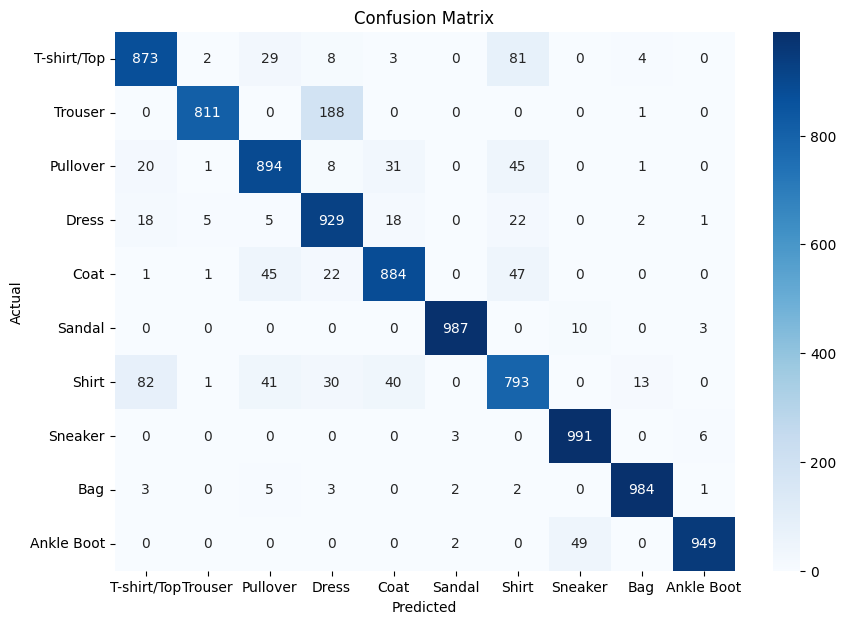

In [29]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**loss curve**
shows good results no over or undefitting

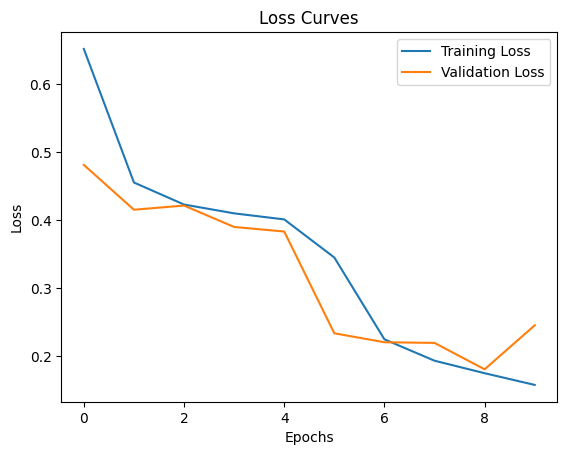

In [28]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

**Accuracy curve**

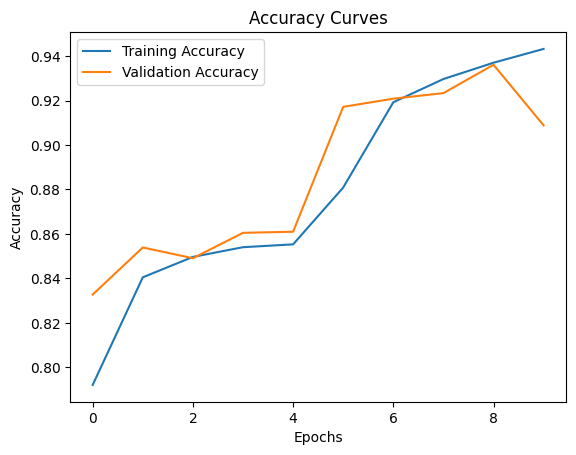

In [22]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

# Comparison-
exportind the validation data from the CNN notebook,showing both and creating a curve to compare.



In [23]:
import pandas as pd

# Manually copy CNN metrics
cnn_metrics = {
    "Epochs": list(range(1, 16)),
    "Validation Accuracy": [84.30, 87.43, 87.27, 89.13, 89.50, 90.14, 89.63, 90.88, 90.42, 91.33, 91.88, 91.83, 91.95, 91.97, 91.42],
    "Validation Loss": [0.4390, 0.3568, 0.3432, 0.3160, 0.2926, 0.2663, 0.2879, 0.2565, 0.2588, 0.2495, 0.2301, 0.2286, 0.2244, 0.2232, 0.2323]
}

# Convert to DataFrame for easy visualization
df_cnn = pd.DataFrame(cnn_metrics)
print("CNN Metrics:")
print(df_cnn)

CNN Metrics:
    Epochs  Validation Accuracy  Validation Loss
0        1                84.30           0.4390
1        2                87.43           0.3568
2        3                87.27           0.3432
3        4                89.13           0.3160
4        5                89.50           0.2926
5        6                90.14           0.2663
6        7                89.63           0.2879
7        8                90.88           0.2565
8        9                90.42           0.2588
9       10                91.33           0.2495
10      11                91.88           0.2301
11      12                91.83           0.2286
12      13                91.95           0.2244
13      14                91.97           0.2232
14      15                91.42           0.2323


In [24]:
resnet_metrics = {
    "Epochs": list(range(1, 11)),
    "Validation Accuracy": [82.59, 84.47, 85.03, 85.92, 85.84, 89.85, 90.90, 92.85, 93.27, 92.80],
    "Validation Loss": [0.4984, 0.4346, 0.4110, 0.4031, 0.3967, 0.2771, 0.2479, 0.2056, 0.1847, 0.1976]
}

# Convert to DataFrame
df_resnet = pd.DataFrame(resnet_metrics)
print("ResNet Metrics:")
print(df_resnet)

ResNet Metrics:
   Epochs  Validation Accuracy  Validation Loss
0       1                82.59           0.4984
1       2                84.47           0.4346
2       3                85.03           0.4110
3       4                85.92           0.4031
4       5                85.84           0.3967
5       6                89.85           0.2771
6       7                90.90           0.2479
7       8                92.85           0.2056
8       9                93.27           0.1847
9      10                92.80           0.1976


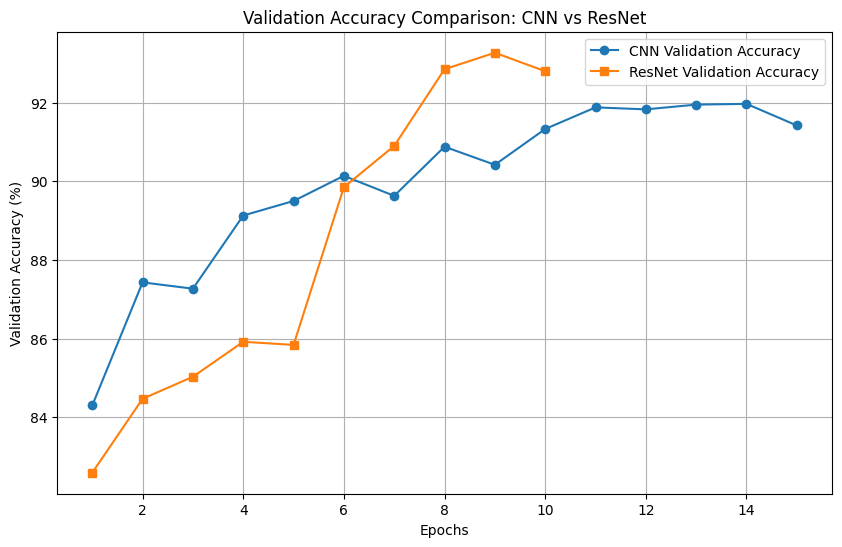

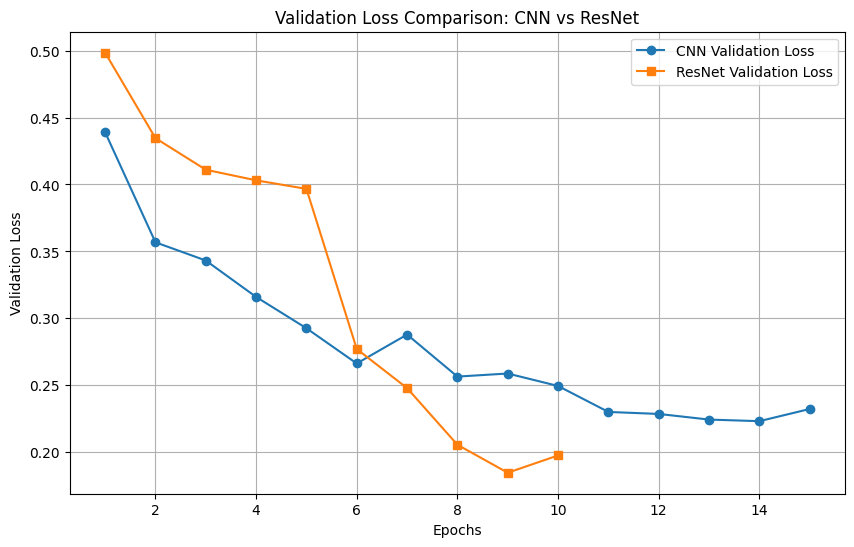

In [25]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(cnn_metrics["Epochs"], cnn_metrics["Validation Accuracy"], label='CNN Validation Accuracy', marker='o')
plt.plot(resnet_metrics["Epochs"], resnet_metrics["Validation Accuracy"], label='ResNet Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison: CNN vs ResNet')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(cnn_metrics["Epochs"], cnn_metrics["Validation Loss"], label='CNN Validation Loss', marker='o')
plt.plot(resnet_metrics["Epochs"], resnet_metrics["Validation Loss"], label='ResNet Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison: CNN vs ResNet')
plt.legend()
plt.grid(True)
plt.show()

# Comparison table to sum up the differances.

In [27]:


import pandas as pd
from IPython.display import display, HTML

# Comparison data
comparison_data_updated = {
    "Metric": [
        "Validation Accuracy (Peak)",
        "Validation Loss (Min)",
        "Convergence Epoch (Best Performance)",
        "Number of Epochs",
        "Transformations Applied",
        "Batch Size",
        "Precision (Macro Avg)",
        "F1-Score (Macro Avg)",
        "Recall (Macro Avg)"
    ],
    "CNN": [
        "91.97%",
        "0.2232",
        "15",
        "15",
        "Normalization,RandomHorizontalFlip, ToTensor ",
        "64",
        "91%",
        "91%",
        "91%"
    ],
    "ResNet": [
        "93.61%",
        "0.157",
        "9",
        "10",
        "Normalization, Resize, Grayscale, RandomHorizontalFlip, ToTensor  ",
        "32",
        "93%",
        "93%",
        "93%"
    ]
}

# Convert to DataFrame
comparison_df_updated = pd.DataFrame(comparison_data_updated)

# Style the DataFrame
styled_df = comparison_df_updated.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#343a40'),
                                 ('color', 'white'),
                                 ('font-weight', 'bold'),
                                 ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center'),
                                 ('background-color', '#454d55'),
                                 ('color', 'white')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'),
                                     ('width', '100%'),
                                    ('background-color', '#343a40')]},
    {'selector': 'th, td', 'props': [('border', '1px solid #6c757d'),
                                      ('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#495057')]}
])
# Display the styled table
display(styled_df)


,Metric,CNN,ResNet
0,Validation Accuracy (Peak),91.97%,93.61%
1,Validation Loss (Min),0.2232,0.157
2,Convergence Epoch (Best Performance),15,9
3,Number of Epochs,15,10
4,Transformations Applied,"Normalization,RandomHorizontalFlip, ToTensor","Normalization, Resize, Grayscale, RandomHorizontalFlip, ToTensor"
5,Batch Size,64,32
6,Precision (Macro Avg),91%,93%
7,F1-Score (Macro Avg),91%,93%
8,Recall (Macro Avg),91%,93%


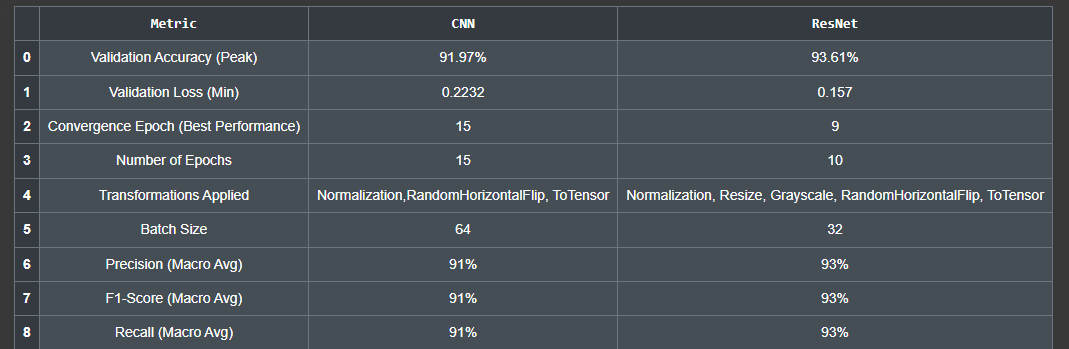

# ResNet Conclusions

From the results, we observed a significant improvement in performance after unfreezing the ResNet layers at epoch 5.

Initially, the pre-trained model achieved a validation accuracy of approximately 87% without fine-tuning.

However, once the layers were unfrozen and the model started learning the specific patterns in the new dataset, there was a notable jump in accuracy.

**The key difference can be seen between epoch 5 and epoch 6**

Epoch [5/10], Validation Loss: 0.3832, Validation Accuracy: 0.8610

Unfreezing all layers!

Epoch [6/10], Training Loss: 0.3450, Training Accuracy: 0.8809

This highlights a crucial insight: while a pretrained model provides a strong starting point as we saw(starting at a relativly high accuracy Epoch [1/10], Training Loss: 0.6538, Training Accuracy: 0.7855) ,

fine-tuning the model to adapt to the specific characteristics of the new dataset is essential for achieving optimal performance.

The pre-trained weights act as a foundation, but learning the nuances of the new data significantly enhances the models accuracy and generalization ability.

# Final Conclusion

from my results it seems the ResNet model did preform better then the CNN model.



*   ResNet achieved its peak validation accuracy of 93.27% in just 9 epochs, compared to the CNN which took 15 epochs to reach 91.97%. This highlights ResNet's efficiency, especially when fine-tuned using pre-trained weights

*   ResNet outperformed the CNN by a small margin in validation accuracy (93.27% vs. 91.97%). This shows ResNet's ability to generalize better due to its deeper architecture and transfer learning capabilities.

but in my opnion it is good to notice that Despite being simpler, the CNN
model achieved comparable results with slightly longer training. This suggests that for tasks with sufficient data and simpler feature requirements, a custom CNN can be competitive without the computational overhead of fine-tuning pre-trained models.

to sum up -  we might consider using a simple CNN model for sum data bases but ResNet defently makes life simler and according to my result a bit better overall.


